# Data Exploration - Home Care System

Exploring both datasets before building the models:
- SisFall (fall detection)
- ECG5000 / MIT-BIH (heartbeat anomaly detection)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

SISFALL_PATH = Path(r'C:\Users\MYP\Desktop\Parthiban\Uni\CS_AI\2026_Term_4\ICT304\Assignment\Assignment 1\datasets\SisFall_dataset')
ECG_PATH = Path(r'C:\Users\MYP\Desktop\Parthiban\Uni\CS_AI\2026_Term_4\ICT304\Assignment\Assignment 1\datasets\Heartbeat')
DOCS_PATH = Path(r'C:\Users\MYP\Desktop\Parthiban\Uni\CS_AI\2026_Term_4\ICT304\Assignment\Assignment 1\docs')
DOCS_PATH.mkdir(exist_ok=True)

print(f'SisFall found: {SISFALL_PATH.exists()}')
print(f'ECG found: {ECG_PATH.exists()}')

SisFall found: True
ECG found: True


## SisFall Dataset

In [2]:
# sisfall files are comma separated with a semicolon at the end of each line
# 9 columns: 3 sensors x 3 axes each
def load_sisfall_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    data = []
    for line in lines:
        line = line.strip().rstrip(';')
        if line:
            values = [int(x.strip()) for x in line.split(',')]
            data.append(values)

    columns = [
        'ADXL345_X', 'ADXL345_Y', 'ADXL345_Z',
        'ITG3200_X', 'ITG3200_Y', 'ITG3200_Z',
        'MMA8451Q_X', 'MMA8451Q_Y', 'MMA8451Q_Z'
    ]
    return pd.DataFrame(data, columns=columns)

# quick test
sample = load_sisfall_file(SISFALL_PATH / 'SA01' / 'D01_SA01_R01.txt')
print(f'shape: {sample.shape}')
sample.head()

shape: (19999, 9)


,ADXL345_X,ADXL345_Y,ADXL345_Z,ITG3200_X,ITG3200_Y,ITG3200_Z,MMA8451Q_X,MMA8451Q_Y,MMA8451Q_Z
0,17,-179,-99,-18,-504,-352,76,-697,-279
1,15,-174,-90,-53,-568,-306,48,-675,-254
2,1,-176,-81,-84,-613,-271,-2,-668,-221
3,-10,-180,-77,-104,-647,-227,-34,-697,-175
4,-21,-191,-63,-128,-675,-191,-74,-741,-133


In [3]:
# count everything
total, adl_count, fall_count = 0, 0, 0
young_count, elderly_count = 0, 0
participants = set()
activity_counts = Counter()

for pdir in SISFALL_PATH.iterdir():
    if pdir.is_dir() and pdir.name.startswith('S'):
        participants.add(pdir.name)
        for f in pdir.glob('*.txt'):
            total += 1
            code = f.name.split('_')[0]
            activity_counts[code] += 1
            if code.startswith('D'): adl_count += 1
            elif code.startswith('F'): fall_count += 1
            if pdir.name.startswith('SA'): young_count += 1
            elif pdir.name.startswith('SE'): elderly_count += 1

young_p = len([p for p in participants if p.startswith('SA')])
elderly_p = len([p for p in participants if p.startswith('SE')])

print(f'total files: {total}')
print(f'ADL: {adl_count} ({adl_count/total*100:.1f}%), falls: {fall_count} ({fall_count/total*100:.1f}%)')
print(f'young adults: {young_p} participants ({young_count} files)')
print(f'elderly (60-75yrs): {elderly_p} participants ({elderly_count} files)')

total files: 4505
ADL: 2707 (60.1%), falls: 1798 (39.9%)
young adults: 23 participants (3537 files)
elderly (60-75yrs): 15 participants (968 files)


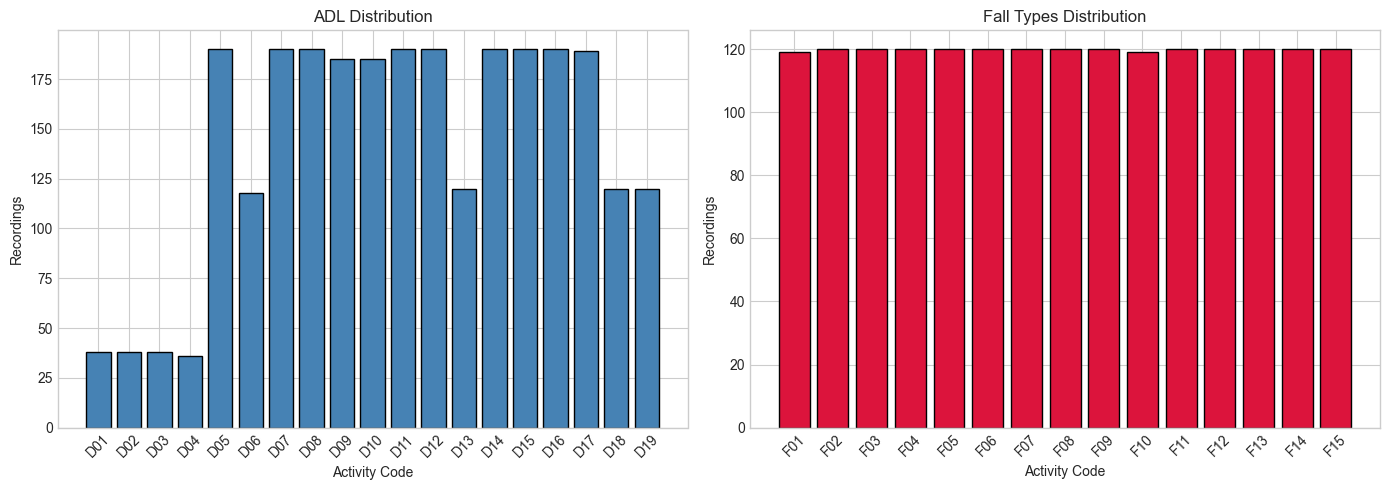

In [4]:
# activity distribution
adl_acts = {k: v for k, v in activity_counts.items() if k.startswith('D')}
fall_acts = {k: v for k, v in activity_counts.items() if k.startswith('F')}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

adl_sorted = dict(sorted(adl_acts.items()))
ax1.bar(adl_sorted.keys(), adl_sorted.values(), color='steelblue', edgecolor='black')
ax1.set_xlabel('Activity Code')
ax1.set_ylabel('Recordings')
ax1.set_title('ADL Distribution')
ax1.tick_params(axis='x', rotation=45)

fall_sorted = dict(sorted(fall_acts.items()))
ax2.bar(fall_sorted.keys(), fall_sorted.values(), color='crimson', edgecolor='black')
ax2.set_xlabel('Activity Code')
ax2.set_ylabel('Recordings')
ax2.set_title('Fall Types Distribution')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(DOCS_PATH / 'sisfall_activity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### Sample time series

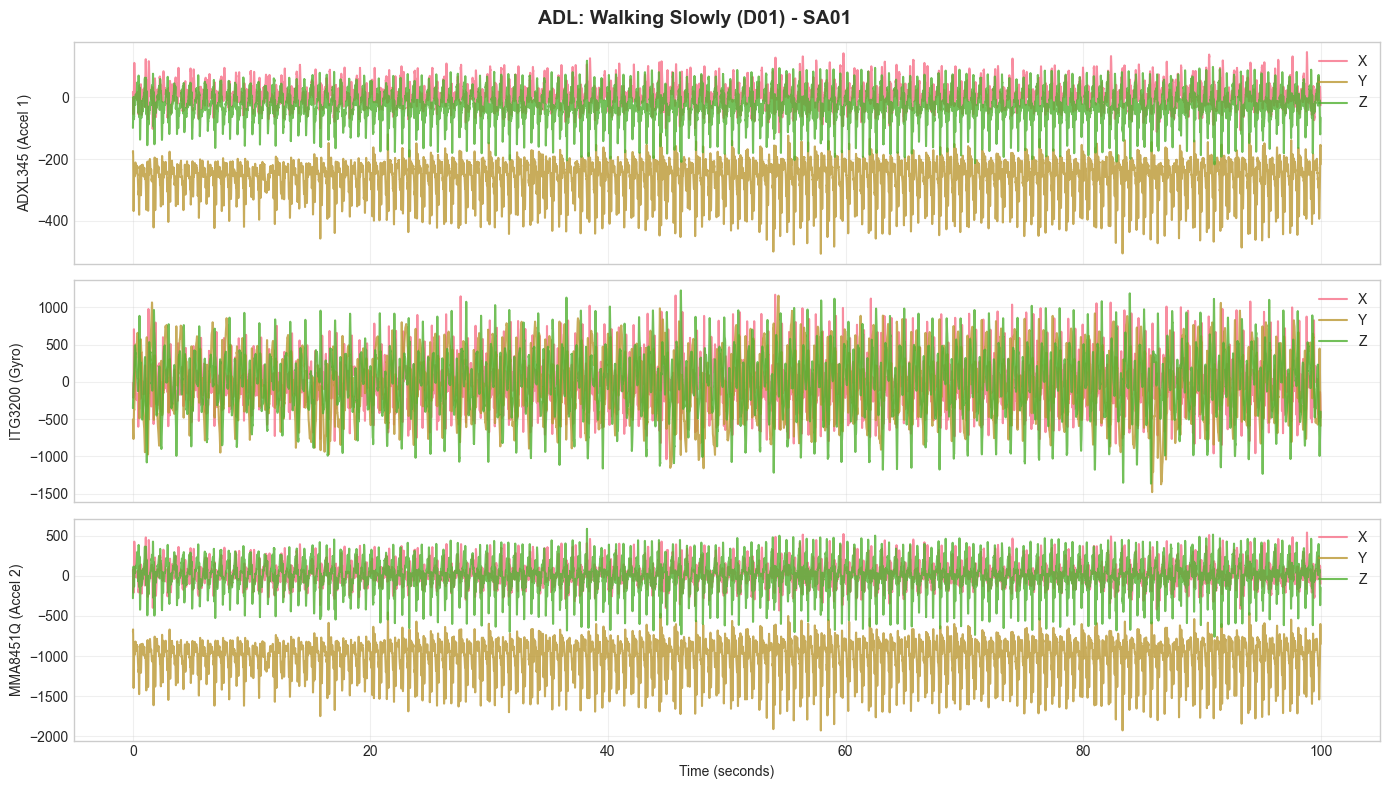

In [5]:
def plot_activity(filepath, title=None):
    data = load_sisfall_file(filepath)
    time = np.arange(len(data)) / 200  # 200Hz

    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

    for ax, sensor, label in zip(axes,
        [('ADXL345_X','ADXL345_Y','ADXL345_Z'), ('ITG3200_X','ITG3200_Y','ITG3200_Z'), ('MMA8451Q_X','MMA8451Q_Y','MMA8451Q_Z')],
        ['ADXL345 (Accel 1)', 'ITG3200 (Gyro)', 'MMA8451Q (Accel 2)']):
        for col in sensor:
            ax.plot(time, data[col], label=col[-1], alpha=0.8)
        ax.set_ylabel(label)
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel('Time (seconds)')
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# walking (ADL)
fig = plot_activity(SISFALL_PATH / 'SA01' / 'D01_SA01_R01.txt', 'ADL: Walking Slowly (D01) - SA01')
plt.savefig(DOCS_PATH / 'sisfall_adl_example.png', dpi=150, bbox_inches='tight')
plt.show()

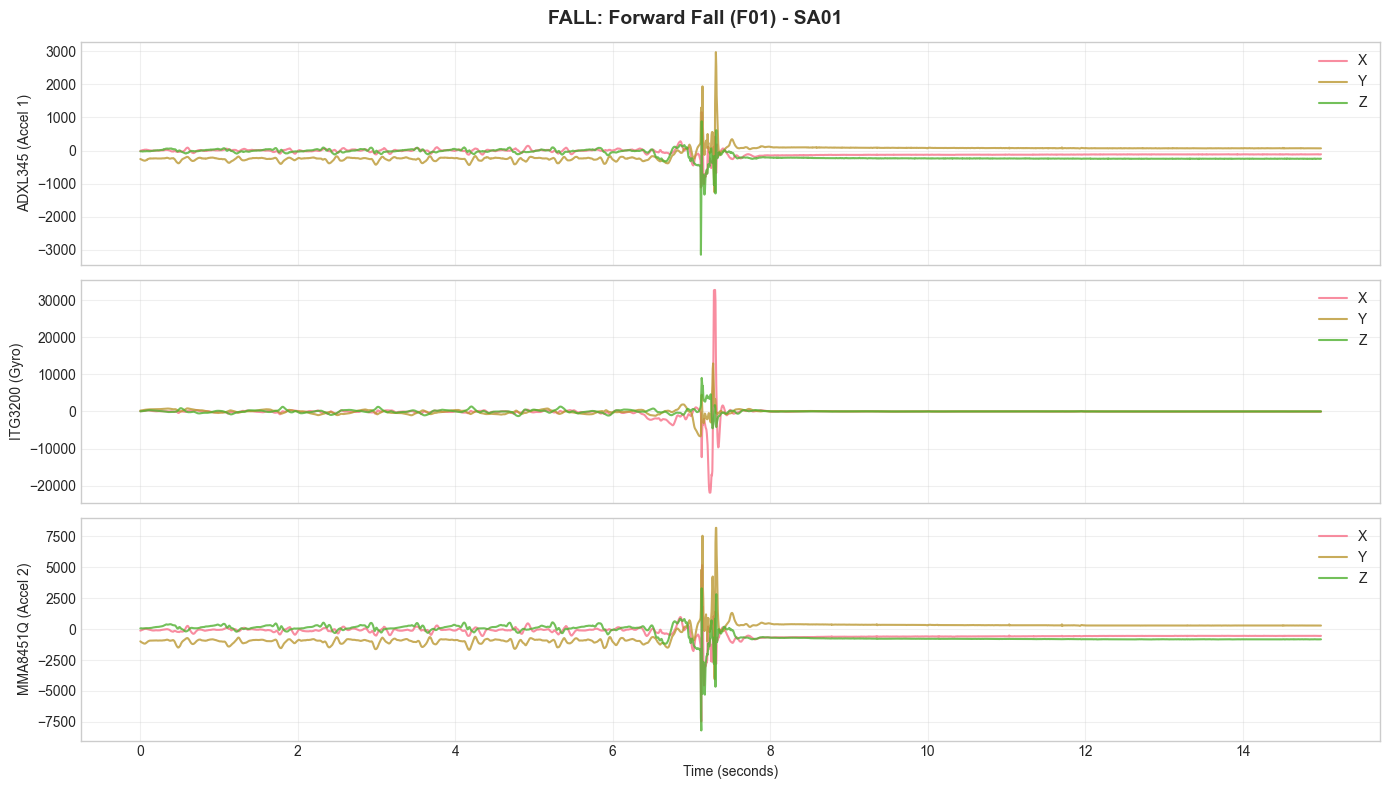

In [6]:
# fall
fig = plot_activity(SISFALL_PATH / 'SA01' / 'F01_SA01_R01.txt', 'FALL: Forward Fall (F01) - SA01')
plt.savefig(DOCS_PATH / 'sisfall_fall_example.png', dpi=150, bbox_inches='tight')
plt.show()

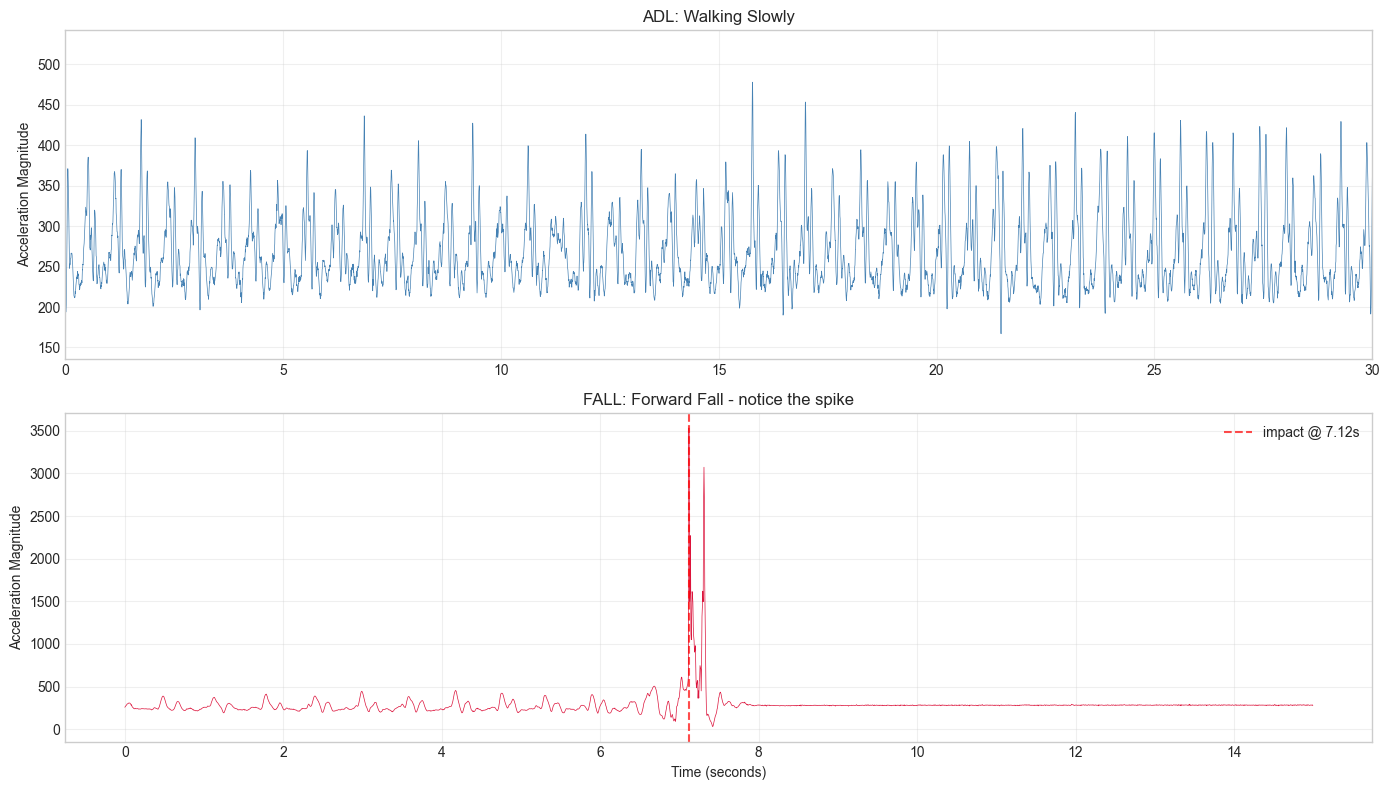

ADL max magnitude: 524
Fall max magnitude: 3532
Fall peak is 6.7x higher


In [7]:
# comparing acceleration magnitude: ADL vs fall
adl_data = load_sisfall_file(SISFALL_PATH / 'SA01' / 'D01_SA01_R01.txt')
fall_data = load_sisfall_file(SISFALL_PATH / 'SA01' / 'F01_SA01_R01.txt')

adl_mag = np.sqrt(adl_data['ADXL345_X']**2 + adl_data['ADXL345_Y']**2 + adl_data['ADXL345_Z']**2)
fall_mag = np.sqrt(fall_data['ADXL345_X']**2 + fall_data['ADXL345_Y']**2 + fall_data['ADXL345_Z']**2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

ax1.plot(np.arange(len(adl_mag))/200, adl_mag, color='steelblue', linewidth=0.5)
ax1.set_ylabel('Acceleration Magnitude')
ax1.set_title('ADL: Walking Slowly')
ax1.set_xlim(0, 30)
ax1.grid(True, alpha=0.3)

ax2.plot(np.arange(len(fall_mag))/200, fall_mag, color='crimson', linewidth=0.5)
ax2.set_ylabel('Acceleration Magnitude')
ax2.set_xlabel('Time (seconds)')
ax2.set_title('FALL: Forward Fall - notice the spike')
ax2.grid(True, alpha=0.3)

fall_peak = np.argmax(fall_mag) / 200
ax2.axvline(x=fall_peak, color='red', linestyle='--', alpha=0.7, label=f'impact @ {fall_peak:.2f}s')
ax2.legend()

plt.tight_layout()
plt.savefig(DOCS_PATH / 'sisfall_adl_vs_fall.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'ADL max magnitude: {adl_mag.max():.0f}')
print(f'Fall max magnitude: {fall_mag.max():.0f}')
print(f'Fall peak is {fall_mag.max()/adl_mag.max():.1f}x higher')

### Elderly vs young adult walking

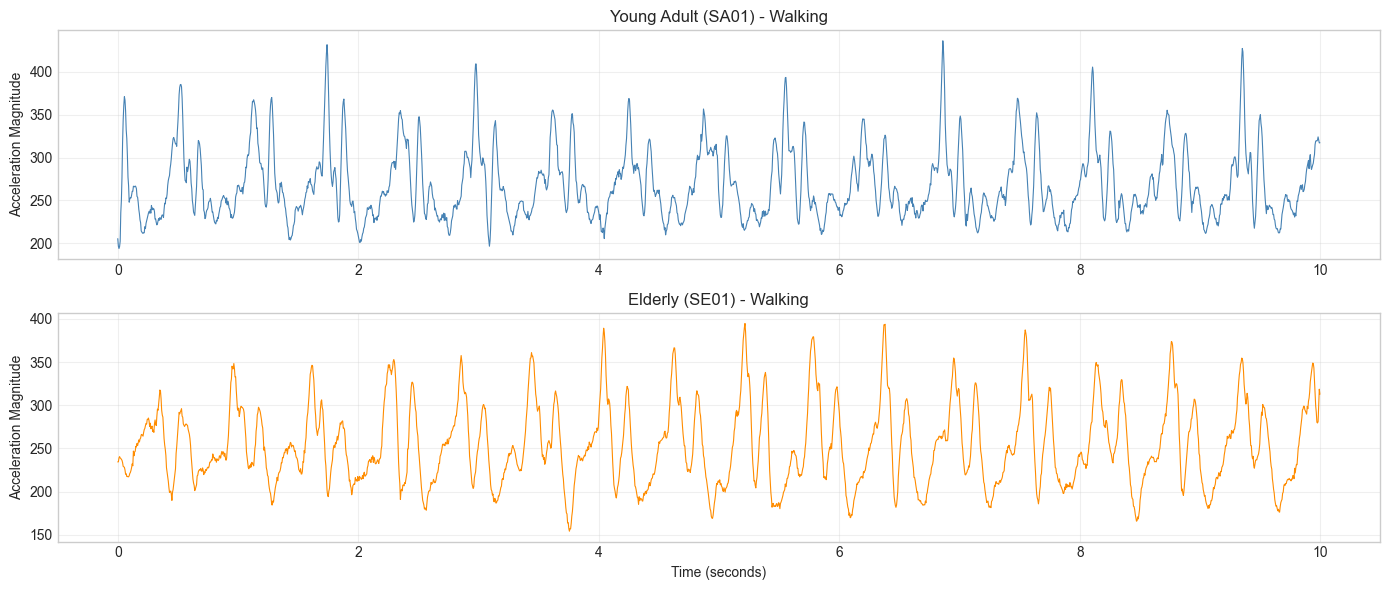

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))

young_data = load_sisfall_file(SISFALL_PATH / 'SA01' / 'D01_SA01_R01.txt')
young_mag = np.sqrt(young_data['ADXL345_X']**2 + young_data['ADXL345_Y']**2 + young_data['ADXL345_Z']**2)
ax1.plot(np.arange(2000)/200, young_mag[:2000], color='steelblue', linewidth=0.8)
ax1.set_ylabel('Acceleration Magnitude')
ax1.set_title('Young Adult (SA01) - Walking')
ax1.grid(True, alpha=0.3)

elderly_data = load_sisfall_file(SISFALL_PATH / 'SE01' / 'D01_SE01_R01.txt')
elderly_mag = np.sqrt(elderly_data['ADXL345_X']**2 + elderly_data['ADXL345_Y']**2 + elderly_data['ADXL345_Z']**2)
ax2.plot(np.arange(2000)/200, elderly_mag[:2000], color='darkorange', linewidth=0.8)
ax2.set_ylabel('Acceleration Magnitude')
ax2.set_xlabel('Time (seconds)')
ax2.set_title('Elderly (SE01) - Walking')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DOCS_PATH / 'sisfall_young_vs_elderly.png', dpi=150, bbox_inches='tight')
plt.show()

## ECG5000 Dataset

In [9]:
train_df = pd.read_csv(ECG_PATH / 'mitbih_train.csv', header=None)
test_df = pd.read_csv(ECG_PATH / 'mitbih_test.csv', header=None)

X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values.astype(int)
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values.astype(int)

class_names = {0: 'Normal', 1: 'R-on-T PVC', 2: 'PVC', 3: 'Supra-ventricular', 4: 'Unclassified'}

print(f'train: {len(train_df)} samples, test: {len(test_df)} samples')
print(f'{train_df.shape[1]-1} timesteps per sample')
print()
for c in sorted(np.unique(y_train)):
    n = np.sum(y_train == c)
    print(f'  class {c} ({class_names[c]}): {n:,} ({n/len(y_train)*100:.2f}%)')

normal_n = np.sum(y_train == 0)
anomaly_n = len(y_train) - normal_n
print(f'\nnormal: {normal_n:,} ({normal_n/len(y_train)*100:.1f}%), anomaly: {anomaly_n:,} ({anomaly_n/len(y_train)*100:.1f}%)')

train: 87554 samples, test: 21892 samples
187 timesteps per sample

  class 0 (Normal): 72,471 (82.77%)
  class 1 (R-on-T PVC): 2,223 (2.54%)
  class 2 (PVC): 5,788 (6.61%)
  class 3 (Supra-ventricular): 641 (0.73%)
  class 4 (Unclassified): 6,431 (7.35%)

normal: 72,471 (82.8%), anomaly: 15,083 (17.2%)


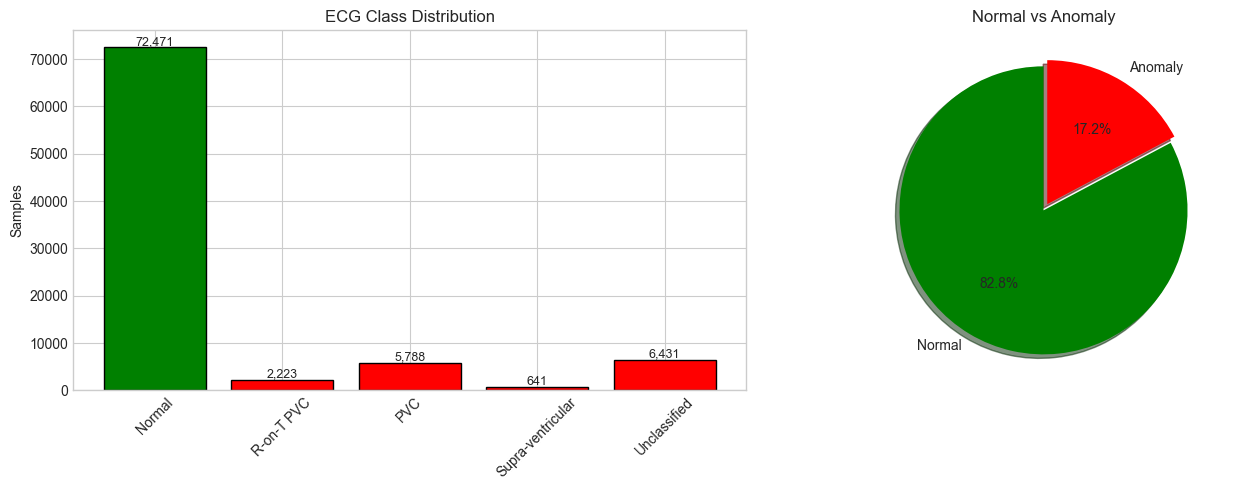

In [10]:
# class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

classes = sorted(np.unique(y_train))
counts = [np.sum(y_train == c) for c in classes]
colors = ['green' if c == 0 else 'red' for c in classes]
bars = ax1.bar([class_names[c] for c in classes], counts, color=colors, edgecolor='black')
ax1.set_ylabel('Samples')
ax1.set_title('ECG Class Distribution')
ax1.tick_params(axis='x', rotation=45)
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, f'{count:,}', ha='center', fontsize=9)

ax2.pie([normal_n, anomaly_n], labels=['Normal', 'Anomaly'], colors=['green', 'red'],
        autopct='%1.1f%%', explode=(0, 0.05), shadow=True, startangle=90)
ax2.set_title('Normal vs Anomaly')

plt.tight_layout()
plt.savefig(DOCS_PATH / 'ecg_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### Sample heartbeats

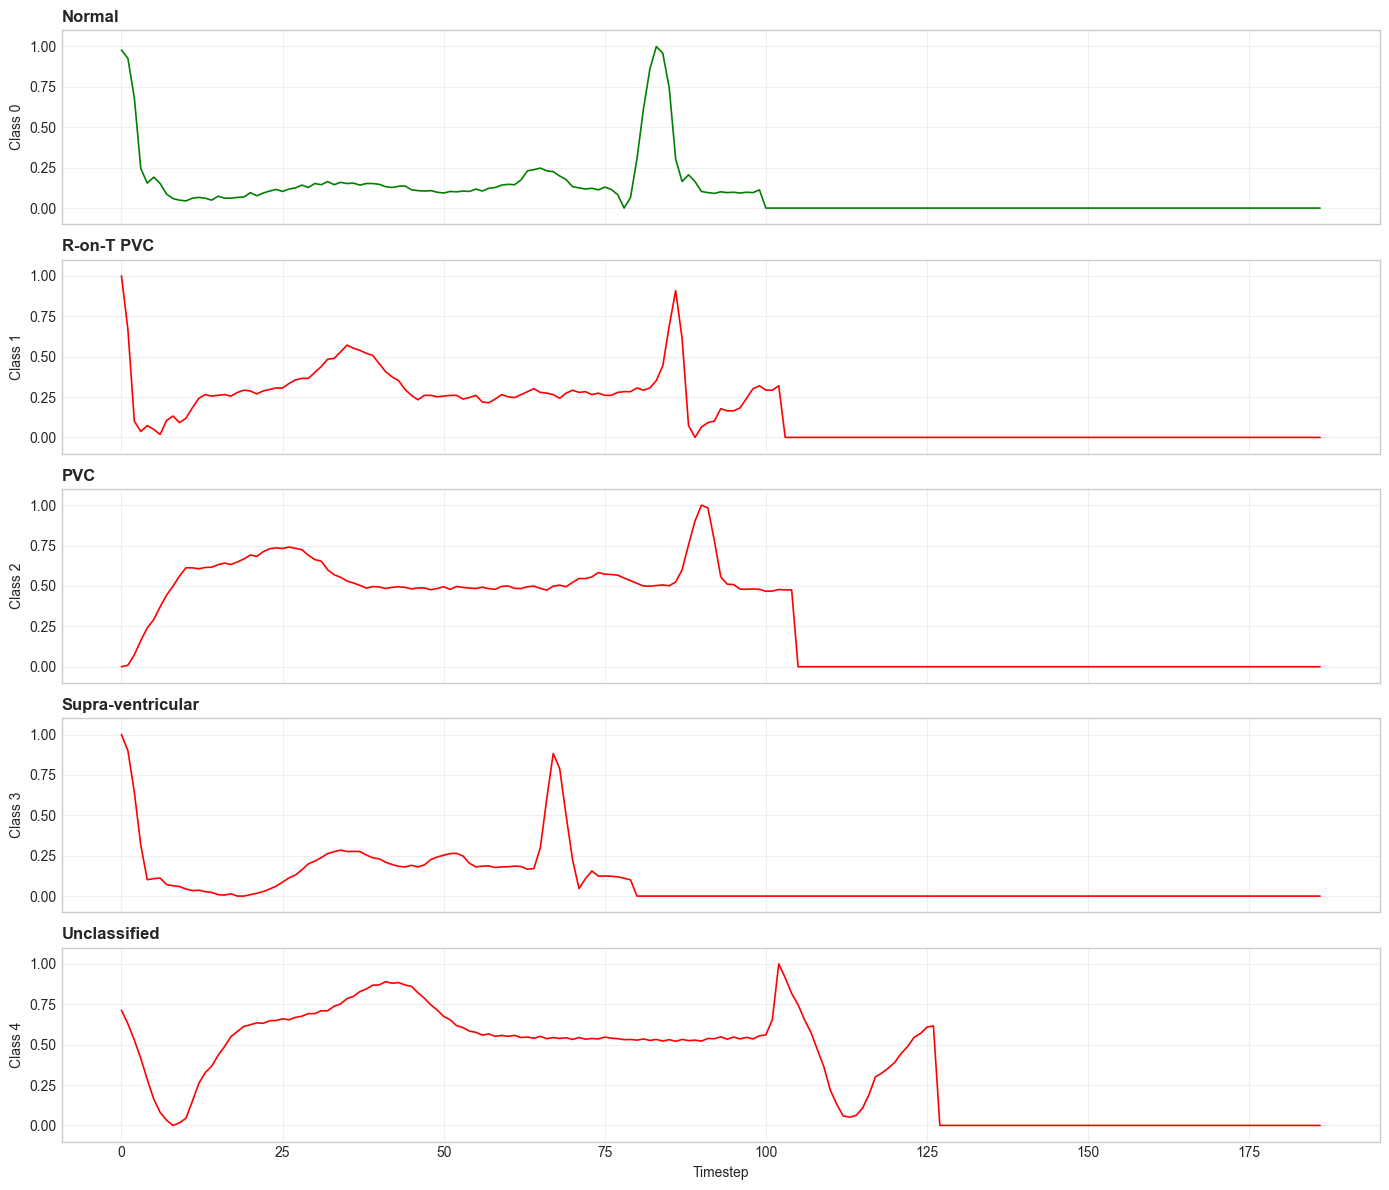

In [11]:
# one sample per class
fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

for class_id in range(5):
    idx = np.where(y_train == class_id)[0][0]
    ax = axes[class_id]
    color = 'green' if class_id == 0 else 'red'
    ax.plot(X_train[idx], color=color, linewidth=1.2)
    ax.set_ylabel(f'Class {class_id}')
    ax.set_title(class_names[class_id], fontweight='bold', loc='left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.1)

axes[-1].set_xlabel('Timestep')
plt.tight_layout()
plt.savefig(DOCS_PATH / 'ecg_sample_heartbeats.png', dpi=150, bbox_inches='tight')
plt.show()

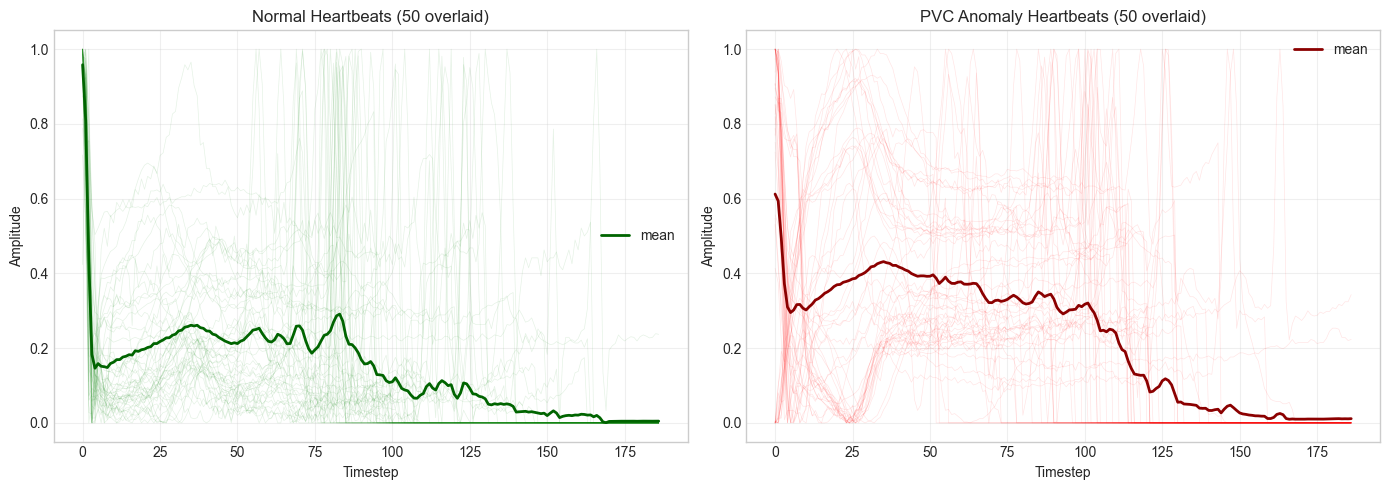

In [12]:
# overlaying 50 normal vs 50 anomaly (PVC) heartbeats
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

normal_idx = np.where(y_train == 0)[0][:50]
for i in normal_idx:
    ax1.plot(X_train[i], color='green', alpha=0.1, linewidth=0.5)
ax1.plot(X_train[normal_idx].mean(axis=0), color='darkgreen', linewidth=2, label='mean')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Amplitude')
ax1.set_title('Normal Heartbeats (50 overlaid)')
ax1.legend()
ax1.grid(True, alpha=0.3)

anomaly_idx = np.where(y_train == 2)[0][:50]
for i in anomaly_idx:
    ax2.plot(X_train[i], color='red', alpha=0.1, linewidth=0.5)
ax2.plot(X_train[anomaly_idx].mean(axis=0), color='darkred', linewidth=2, label='mean')
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Amplitude')
ax2.set_title('PVC Anomaly Heartbeats (50 overlaid)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DOCS_PATH / 'ecg_normal_vs_anomaly_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

### Basic stats per class

In [13]:
rows = []
for c in range(5):
    samples = X_train[y_train == c]
    rows.append({
        'Class': class_names[c],
        'Count': len(samples),
        'Mean': samples.mean(),
        'Std': samples.std(),
        'Min': samples.min(),
        'Max': samples.max()
    })

pd.DataFrame(rows)

,Class,Count,Mean,Std,Min,Max
0,Normal,72471,0.161896,0.217563,0.0,1.0
1,R-on-T PVC,2223,0.194778,0.214630,0.0,1.0
2,PVC,5788,0.243849,0.262343,0.0,1.0
3,Supra-ventricular,641,0.107253,0.193049,0.0,1.0
4,Unclassified,6431,0.250854,0.264309,0.0,1.0
